In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [2]:
stock_data = pd.read_csv("S&P 500 Historical 5 Years.csv", index_col=0)
stock_data = stock_data.iloc[::-1]
stock_data = stock_data.reset_index()

Text(0, 0.5, 'Close/Last Price')

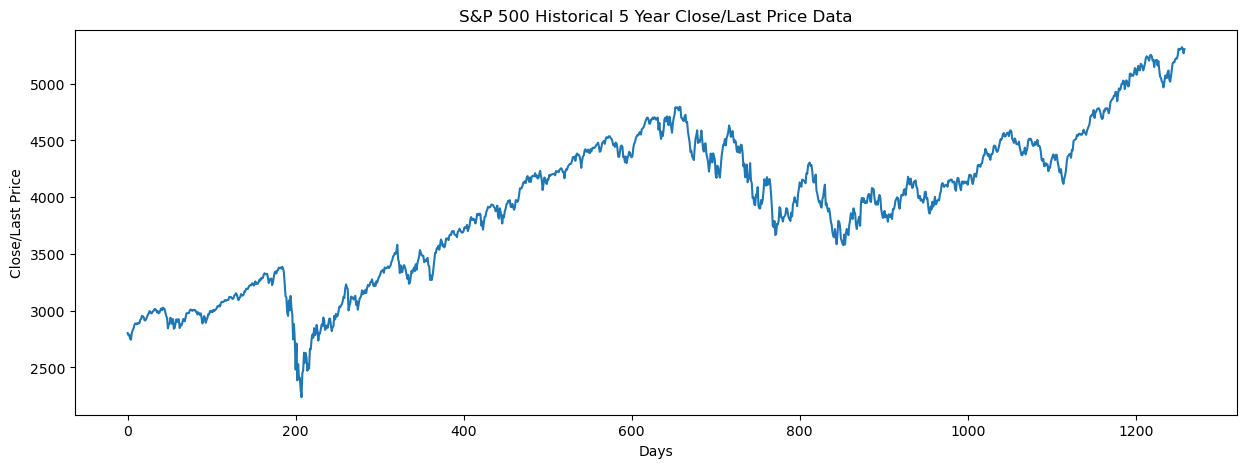

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(stock_data['Close/Last'])
plt.title('S&P 500 Historical 5 Year Close/Last Price Data')
plt.xlabel('Days')
plt.ylabel('Close/Last Price')


In [4]:
#Order of integration
adf = adfuller(x=stock_data['Close/Last'], 
                  autolag='BIC')

adf

(-0.9107408704437959,
 0.7844147187258448,
 9,
 1249,
 {'1%': -3.4355964295197743,
  '5%': -2.863856825923603,
  '10%': -2.5680035060041626},
 13009.131328796784)

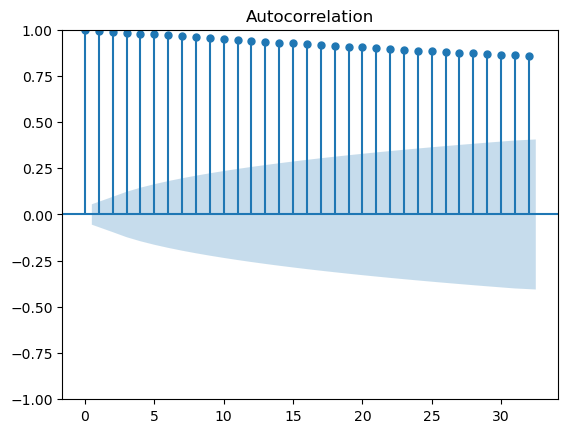

In [5]:
#Autocorrelation function
plot_acf(stock_data['Close/Last'])
plt.show()

In [6]:
#Significant MA Lags

acf_coef = acf(stock_data['Close/Last'], alpha=.05)
sig_acf = []
for i in range(1, len(acf_coef[0])):
    if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
        sig_acf.append(i)
    elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
        sig_acf.append(i)

sig_acf

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

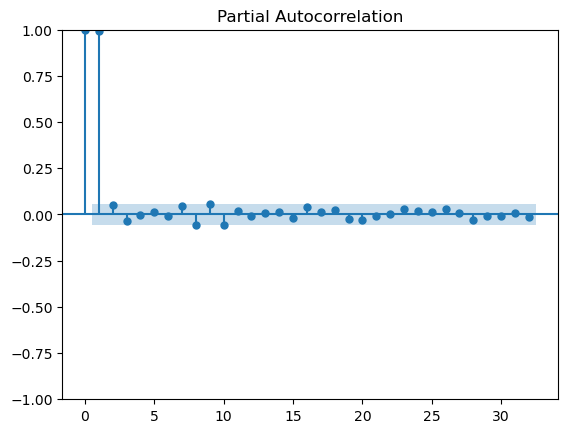

In [7]:
plot_pacf(stock_data['Close/Last'])
plt.show()

In [8]:
#Significant AR lags:
pacf_coef = pacf(stock_data['Close/Last'], alpha=.05)
sig_pacf = []
for i in range(1, len(pacf_coef[0])):
    if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
        sig_pacf.append(i)
    elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
        sig_pacf.append(i)

sig_pacf

[1, 2, 8, 9, 10]

In [9]:
def check_stationarity(series):
    adf_result = adfuller(series)
    if adf_result[1] <= 0.05:
        return 0
    else:
        return 1
    
def get_significant_lags(coefficients):
    lags = []
    for i in range(1, len(coefficients[0])):
        if (coefficients[0][i] > (coefficients[1][i][1] - coefficients[0][i])) or (coefficients[0][i] < (coefficients[1][i][0] - coefficients[0][i])):
            lags.append(i)
    return lags

In [10]:
def arima_model(df, attribute, forecast_steps):
    d = check_stationarity(df[attribute])
    p = get_significant_lags(pacf(df[attribute], alpha=0.05))
    q = get_significant_lags(acf(df[attribute], alpha=0.05))
    
    if d == 1:
        trend = 't'
    else:
        trend = 'c'

    #ARIMA(p,d,q) Model
    model = ARIMA(endog = df[attribute],
                  order = (p, d, q),
                  trend = trend).fit(method_kwargs={'maxiter': 2000})
    
    forecast = model.get_forecast(forecast_steps)

    predict = model.predict()
    
    return model, forecast.summary_frame(), model.summary(), predict


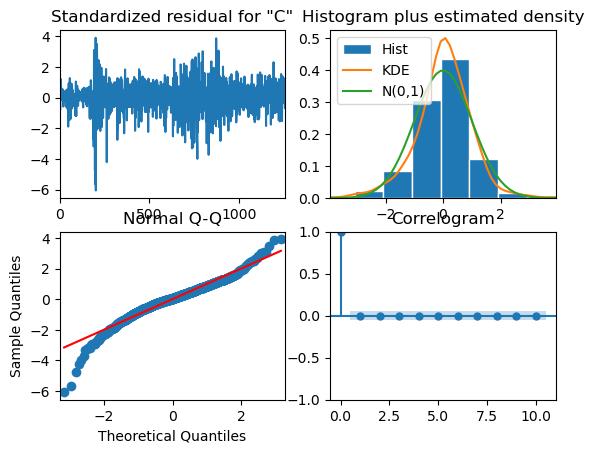

In [13]:
model, forcast_summary, model_summary, predict = arima_model(df=stock_data, attribute='Close/Last', forecast_steps=10)

model.plot_diagnostics()
plt.show()

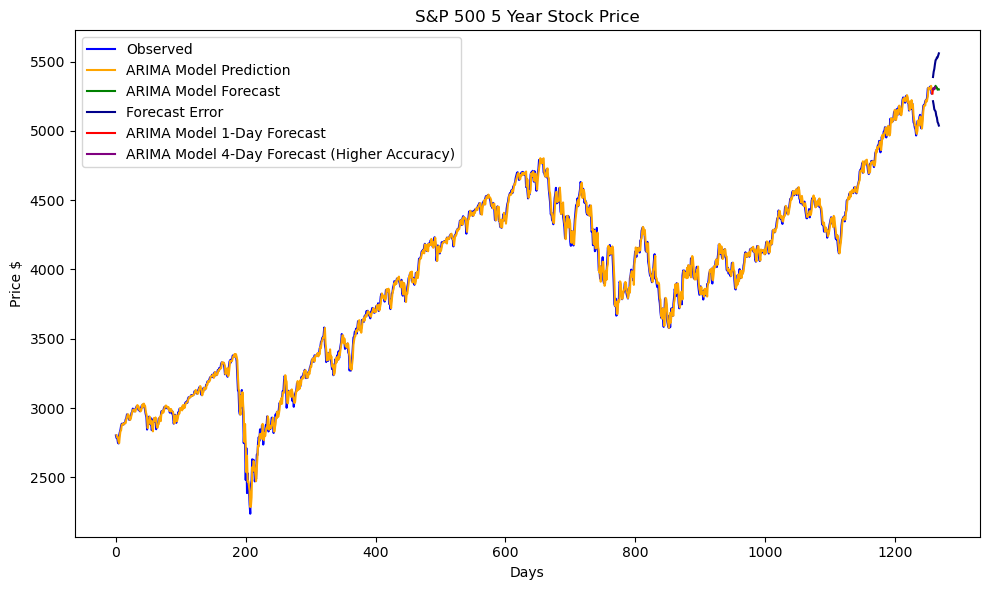

In [14]:
plt.figure(figsize=(10, 6))

# Observed data
plt.plot(stock_data.index, stock_data['Close/Last'], label='Observed', linestyle='-', color='blue')

# ARIMA Model Prediction
plt.plot(predict.index[1:], predict[1:], label='ARIMA Model Prediction', linestyle='-', color='orange')

# ARIMA Model Forecast
plt.plot(forcast_summary.index, forcast_summary['mean'], label='ARIMA Model Forecast', linestyle='-', color='green')

# Forecast Error
plt.plot(forcast_summary.index, forcast_summary['mean_ci_lower'], label='Forecast Error', linestyle='-', color='darkblue')
plt.plot(forcast_summary.index, forcast_summary['mean_ci_upper'], linestyle='-', color='darkblue', label='_nolegend_')

# ARIMA Model 1-Day Forecast
plt.plot([predict.index[-1], forcast_summary.index[0]], [predict.iloc[-1], forcast_summary['mean'].iloc[0]], label='ARIMA Model 1-Day Forecast', linestyle='-', color='red')

# ARIMA Model 4-Day Forecast (Higher Accuracy)
plt.plot(forcast_summary.index[:4], forcast_summary['mean'].iloc[:4], label='ARIMA Model 4-Day Forecast (Higher Accuracy)', linestyle='-', color='purple')

# Titles and labels
plt.title('S&P 500 5 Year Stock Price')
plt.xlabel('Days')
plt.ylabel('Price $')

# Legend
plt.legend()

# Layout adjustments
plt.tight_layout()

# Show plot
plt.show()


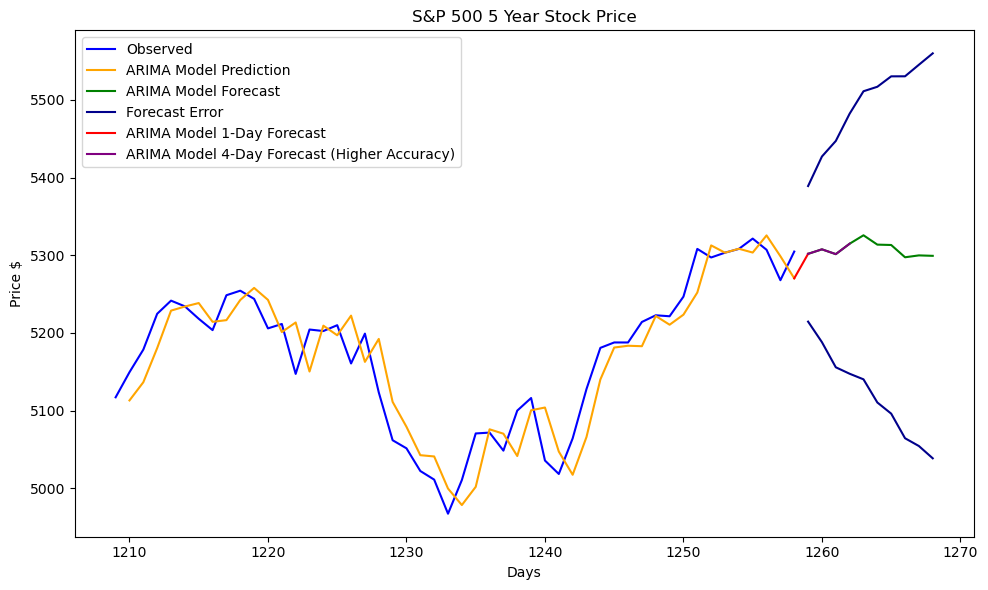

In [15]:
plt.figure(figsize=(10, 6))

# Observed data
plt.plot(stock_data.index[-50:], stock_data['Close/Last'][-50:], label='Observed', linestyle='-', color='blue')

# ARIMA Model Prediction
plt.plot(predict.index[-49:], predict[-49:], label='ARIMA Model Prediction', linestyle='-', color='orange')

# ARIMA Model Forecast
plt.plot(forcast_summary.index, forcast_summary['mean'], label='ARIMA Model Forecast', linestyle='-', color='green')

# Forecast Error
plt.plot(forcast_summary.index, forcast_summary['mean_ci_lower'], label='Forecast Error', linestyle='-', color='darkblue')
plt.plot(forcast_summary.index, forcast_summary['mean_ci_upper'], linestyle='-', color='darkblue', label='_nolegend_')

# ARIMA Model 1-Day Forecast
plt.plot([predict.index[-1], forcast_summary.index[0]], [predict.iloc[-1], forcast_summary['mean'].iloc[0]], label='ARIMA Model 1-Day Forecast', linestyle='-', color='red')

# ARIMA Model 4-Day Forecast (Higher Accuracy)
plt.plot(forcast_summary.index[:4], forcast_summary['mean'].iloc[:4], label='ARIMA Model 4-Day Forecast (Higher Accuracy)', linestyle='-', color='purple')

# Titles and labels
plt.title('S&P 500 5 Year Stock Price')
plt.xlabel('Days')
plt.ylabel('Price $')

# Legend
plt.legend()

# Layout adjustments
plt.tight_layout()

# Show plot
plt.show()
